In [1]:
sc.applicationId

u'application_1560417165231_26140'

In [2]:
# from IPython.core.display import HTML
# css = open('/data/home/p950ske/test_custom.css').read()
# HTML('<style>{}</style>'.format(css))

In [3]:
import warnings
warnings.filterwarnings('ignore')

from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *

import numpy as np
import pandas as pd
import utiles as ut
import pdb

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE #, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix, recall_score, average_precision_score, accuracy_score, roc_auc_score, roc_curve,f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold


#### 1- Read the raw feature table

In [4]:
df_base = sqlContext.sql("SELECT * FROM ddp_consumerlending_vault.p901cyo_combined_v1")

#### 2- Select segment and see statistics

In [5]:
segment_flag = 1
df_base = df_base.where(df_base.poor_payment_flag == segment_flag)
ut.print_basic_stat(df_base)

Number of records:
102239
Number of features:
143
+-------+------+
|default| count|
+-------+------+
|      1|   689|
|      0|101550|
+-------+------+

None


#### 3- Save the features in cvs

In [6]:
# df_iv_features = pd.read_excel("all_feature_before_selection.xlsx")
# features = list(df_iv_features[df_iv_features.IV>0]['var_name'])
# features = list(features + ['default','disbursement_month','duration_poor_payment_count',
#                             'duration_poor_payment_distinct','max_severity_class','mean_severity_class'])
# file_name = "feature_iv_check_poor_fillna_dt.csv"
# feature_used_pd = pd.read_csv(file_name, sep=",", header=None) 
# features = list(feature_used_pd[0][feature_used_pd[1]>0])
# features = list(features + ['default','disbursement_month','duration_poor_payment_count',
#                             'duration_poor_payment_distinct','max_severity_class','mean_severity_class'])
# df = df_base.select(features)

# from subprocess import call
# df.repartition(1).write.option("header","true").csv('main_table_p_missing_v6.csv')
# call(["hadoop","fs","-copyToLocal", 'main_table_p_missing_v6.csv']) 

#### 4- Preprocessing

In [7]:
drop_features_with_x_missing = 0
fill_missing = 1
drop_features_with_low_var = 0
plot_heatmap = 1

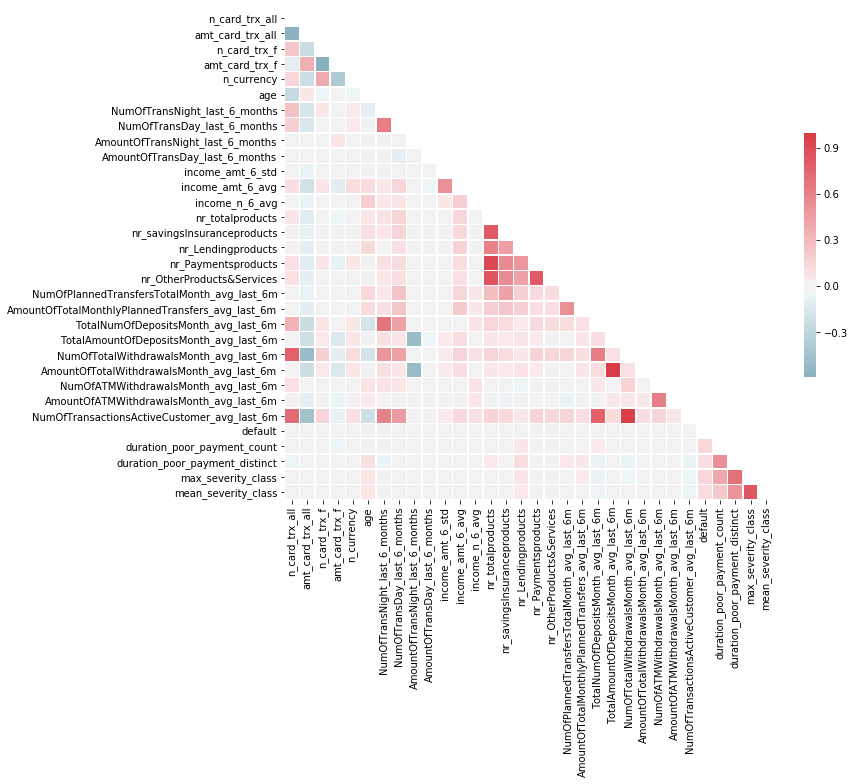

In [8]:
# ===============================================================================
#  1- Selecting features with possitive IV OR just read the table form DDP
# ===============================================================================
df_pd = pd.read_csv('main_table_p_missing_v7.csv')




# ==============================================================
# 2- drop columns with more than threshhold missing
# ==============================================================
if drop_features_with_x_missing == 1:
    data_overview = overview(df.toPandas())
    threshold = 50
    col_to_drop = data_overview[data_overview['percentage of missing']> threshold].index
    print('The following columns are dropped due to missing value:\n')
    print(col_to_drop)
    print(str(np.size(col_to_drop))+' columns are dropped')
    if not col_to_drop.isnull:
        df = df.drop(col_to_drop)
    

# ==============================================================
# 3- Filling the missing values based on data types
# ==============================================================
if fill_missing == 1:
    data_overview = ut.overview(df_pd)
    categorical_features = list(data_overview[data_overview['data type'] == 'object'].index)
    categorical_features.remove('disbursement_month')
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    for col in categorical_features:
        df_pd[col] = imp.fit_transform(df_pd[[col]])


binary_features = [col for col in df_pd if df_pd[col].dropna().value_counts().index.isin([0,1]).all()]
binary_features.remove('default')
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
for col in binary_features:
    df_pd[col] = imp.fit_transform(df_pd[[col]])


numeric_features = list(data_overview[(data_overview['data type'] == 'int64') | (data_overview['data type'] == 'float64')].index)
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
for col in numeric_features:
    df_pd[col] = imp.fit_transform(df_pd[[col]])


# ==============================================================
# 4- Drop features with low variance
# ==============================================================
if drop_features_with_low_var == 1:
    X = df.drop(['default','disbursement_month'])
    y = df.select('default')
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    sel.fit(X)

# ==============================================================
# 5- Create heatmap
# ==============================================================
if plot_heatmap == 1:
    ut.CreateHeatMap(df_pd)

#### 4- Test and train split

In [9]:
train_end_date = '2018-01'
test_end_date = '2018-05'
random = 1
df_train, df_test = ut.test_train_split(df_pd, train_end_date, test_end_date, random)
X_train = df_train.drop(['default'], axis = 1)
y_train = df_train['default']
X_test = df_test.drop(['default'], axis = 1)
y_test = df_test['default']

#### 5- PCA

Minimum required number of components: 14


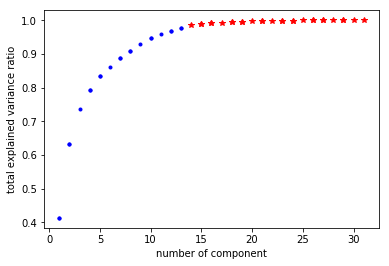

In [10]:
#scalar = RobustScaler(quantile_range = (5,95))
scalar =  MinMaxScaler(feature_range=(0, 1))
X_train_s = scalar.fit_transform(X_train)

N_components = np.linspace(np.shape(X_train_s)[1],1,num=50, dtype = 'int32')
minimum_n = np.shape(X_train_s)[1]

for n in N_components:
    pca = PCA(n_components = n)
    pca.fit(X_train_s)
    if np.sum(pca.explained_variance_ratio_)>0.98:
        plt.plot(n,np.sum(pca.explained_variance_ratio_),'r*')
        minimum_n = n
    else:
        plt.plot(n,np.sum(pca.explained_variance_ratio_),'b.')
    
print('Minimum required number of components: '+ str(minimum_n))
plt.xlabel('number of component')
plt.ylabel('total explained variance ratio')
plt.show()

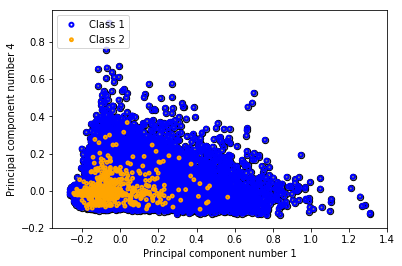

In [11]:
# Choose the number of principle component
pc1 = 1
pc2 = 4

# plot classes in Pc space
ut.plot_classes_in_pc_space(pc1, pc2, minimum_n, X_train_s, y_train )

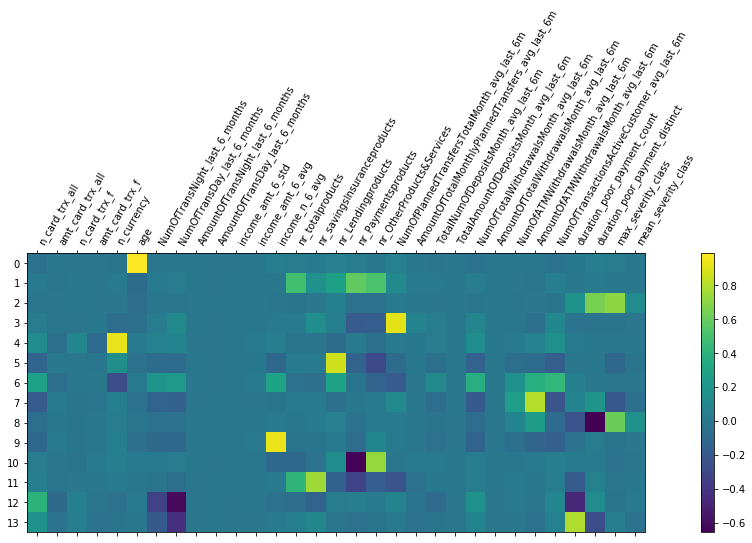

In [12]:
# plot feature importances
warnings.filterwarnings('ignore')
ut.pca_feature_importance_h(minimum_n, X_train_s, df_train )

#### 6- Define possible scaling methods, sampling methods and models

In [13]:
# ==============================================================
# Possible scaling
# ==============================================================
scaling_methods = ['None', 
                   MinMaxScaler(feature_range=(0, 1)),
                   StandardScaler()]

# ==============================================================
# Possible sampling
# ==============================================================
sampling_methods = ["random_oversampled", "random_downsampled","SMOTE_oversampled"] 
#                    "SMOTE_oversampled", "combined"]

# ==============================================================
# Possible models
# ==============================================================
# --------------------------Decision Tree-----------------------
dt_clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, \
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,\
                                max_features=None, random_state=None, max_leaf_nodes=None, \
                                min_impurity_decrease=0.0, min_impurity_split=None, \
                                class_weight={0: 1, 1: 1}, presort=False),
                        cv = 5,
                        param_grid={"class_weight": [{0: 1, 1: 3}, {0: 1, 1: 2}, 'balanced'],
                                    "max_depth": [8, 12]},
                        scoring="accuracy", refit = True)


# --------------------------Random forest-----------------------
rf_clf =  GridSearchCV(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto', max_leaf_nodes=None,
                                            min_impurity_decrease=0.0, min_impurity_split=None),
                        cv = 5,
                        param_grid={"class_weight": [{0: 1, 1: 1}],
                                    "max_depth": [5, 8]},
                        scoring="accuracy", refit = True)
                        

    
# --------------------------Gradient bosting-----------------------
gb_clf = GridSearchCV(GradientBoostingClassifier(loss='deviance', learning_rate=0.01, n_estimators=100, 
                                    subsample=1.0, criterion='friedman_mse', min_samples_split=2,
                                    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=10, 
                                    min_impurity_decrease=0.0, min_impurity_split=None, init=None, 
                                    random_state=41, max_features=None, verbose=0, 
                                    max_leaf_nodes=None, warm_start=True, presort='auto'),
                        cv = 3,
                        param_grid={"n_estimators": [100],
                                    "max_depth": [8],
                                    "learning_rate":[0.1]},
                        scoring="accuracy", refit = True)


# --------------------------Support vector classifier-----------------------
# svc_clf = GridSearchCV(SVC(probability=False, C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated', coef0=0.0, 
#                            shrinking=True, tol=0.001, cache_size=200, 
#                            class_weight={0: 1, 1: 1}, verbose=False, max_iter=-1, decision_function_shape='ovr', 
#                            random_state=42),
#                         cv = 3,
#                         param_grid={"kernel": ["rbf"],
#                                     "degree": [3]},
#                         scoring="accuracy", refit = True)
    

# ----------------------------Neural Network-------------------------
# model_mlp = Sequential()
# model_mlp.add(Dense(12, input_dim=28, activation='relu'))
# model_mlp.add(Dropout(0.2))
# model_mlp.add(Dense(8, activation='relu'))
# model_mlp.add(Dropout(0.2))
# model_mlp.add(Dense(4, activation='relu'))
# model_mlp.add(Dropout(0.2))
# model_mlp.add(Dense(1, kernel_regularizer = l1(0), activation='sigmoid'))
# model_mlp.compile(loss= 'binary_crossentropy', optimizer='adam', metrics= ['accuracy'])
    
    
models = [dt_clf,rf_clf,gb_clf]

#### 7- Different combinations of scaling, sampling and modeling algorithms, save results 

sampling method: random_oversampled
model: DecisionTreeClassifier
scaling method: None
the accuracy on the resampled training data: 0.853491778259


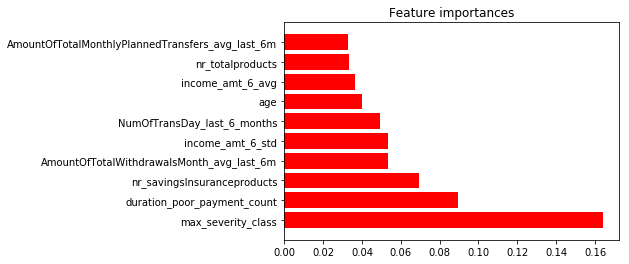

the accuracy on the training data: 0.748554241909


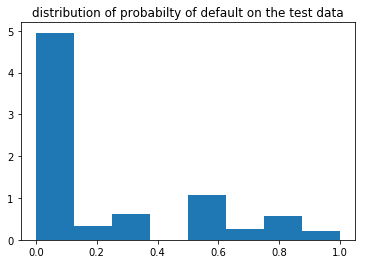

the accuracy on the test data: 0.737578247261


sampling method: random_oversampled
model: DecisionTreeClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 0.853479470264


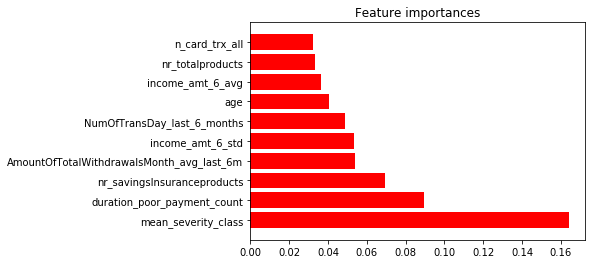

the accuracy on the training data: 0.748529789341


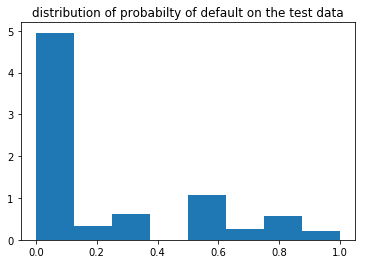

the accuracy on the test data: 0.7376271518


sampling method: random_oversampled
model: DecisionTreeClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 0.853485624262


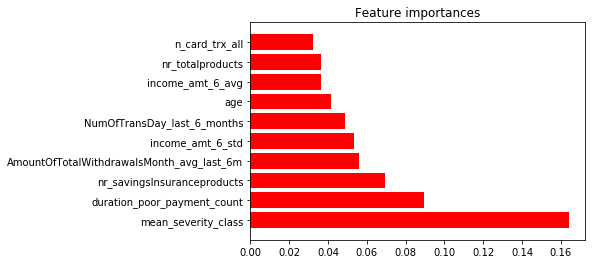

the accuracy on the training data: 0.748542015625


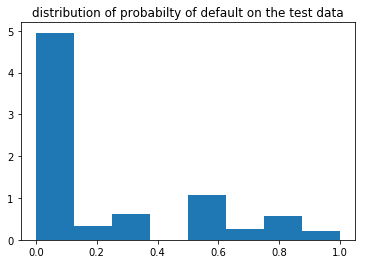

the accuracy on the test data: 0.737724960876


sampling method: random_oversampled
model: RandomForestClassifier
scaling method: None
the accuracy on the resampled training data: 0.849836303663


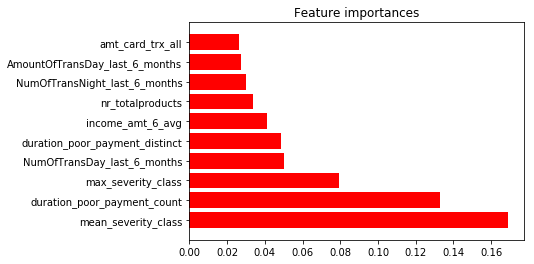

the accuracy on the training data: 0.760291474612


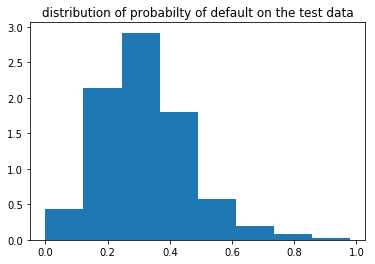

the accuracy on the test data: 0.750342331768


sampling method: random_oversampled
model: RandomForestClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 0.858544210319


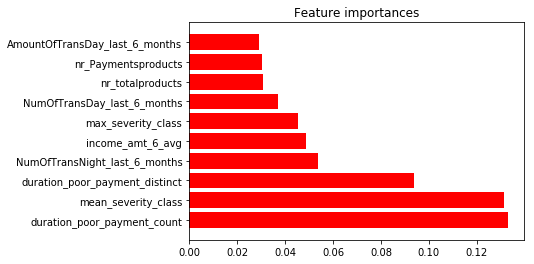

the accuracy on the training data: 0.781088383808


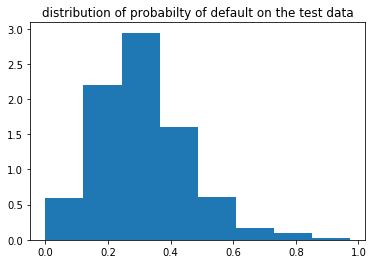

the accuracy on the test data: 0.771126760563


sampling method: random_oversampled
model: RandomForestClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 0.850716325325


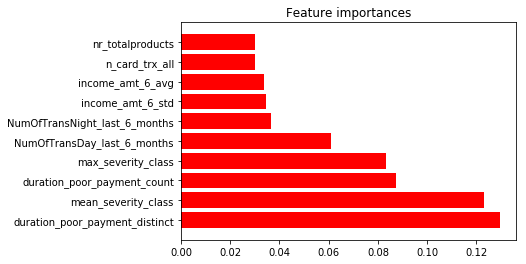

the accuracy on the training data: 0.753701507501


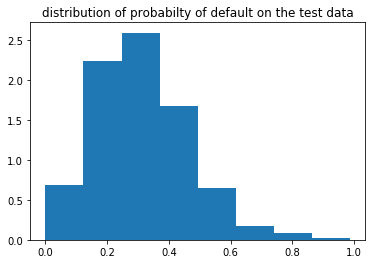

the accuracy on the test data: 0.744718309859


sampling method: random_oversampled
model: GradientBoostingClassifier
scaling method: None
the accuracy on the resampled training data: 0.991113627412


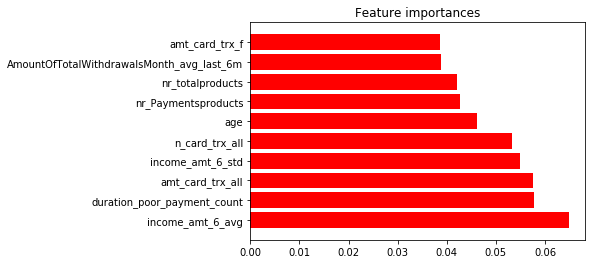

the accuracy on the training data: 0.982345245809


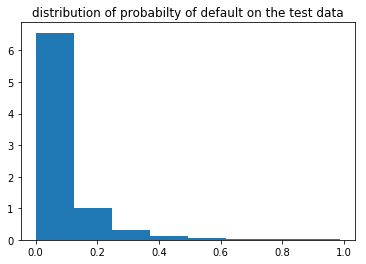

the accuracy on the test data: 0.971879890454


sampling method: random_oversampled
model: GradientBoostingClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 0.991661333202


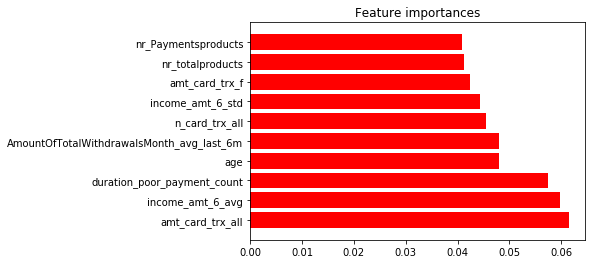

the accuracy on the training data: 0.983433385091


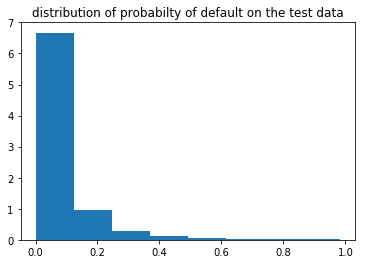

the accuracy on the test data: 0.972809076682


sampling method: random_oversampled
model: GradientBoostingClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 0.991113627412


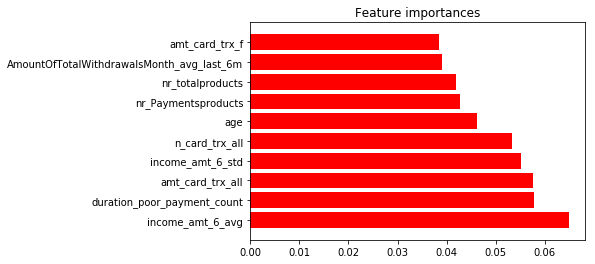

the accuracy on the training data: 0.982345245809


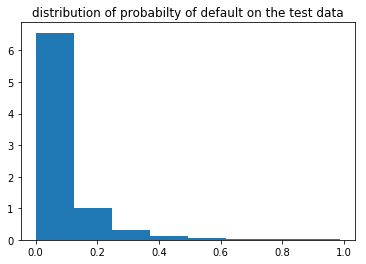

the accuracy on the test data: 0.971830985915


sampling method: random_downsampled
model: DecisionTreeClassifier
scaling method: None
the accuracy on the resampled training data: 0.850828729282


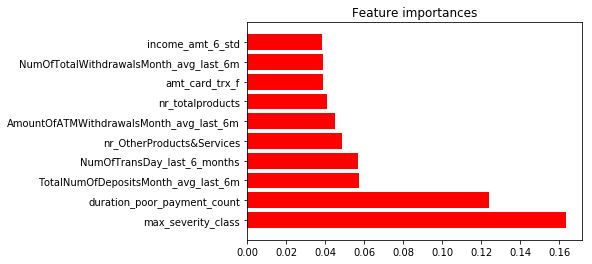

the accuracy on the training data: 0.674169529655


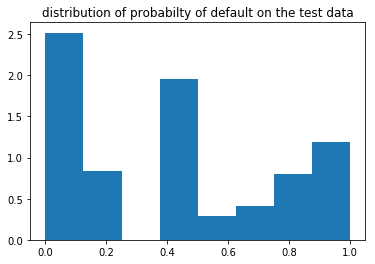

the accuracy on the test data: 0.665590766823


sampling method: random_downsampled
model: DecisionTreeClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 0.850828729282


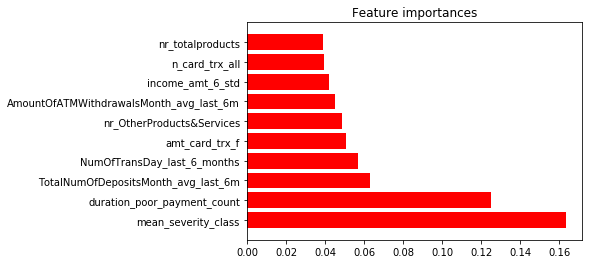

the accuracy on the training data: 0.674255113643


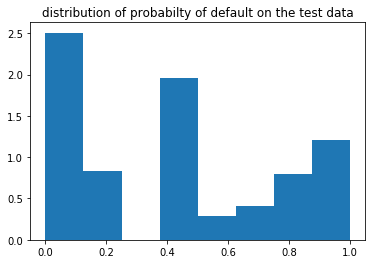

the accuracy on the test data: 0.664368153365


sampling method: random_downsampled
model: DecisionTreeClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 0.850828729282


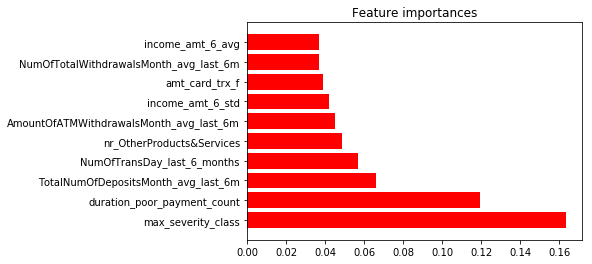

the accuracy on the training data: 0.673387047475


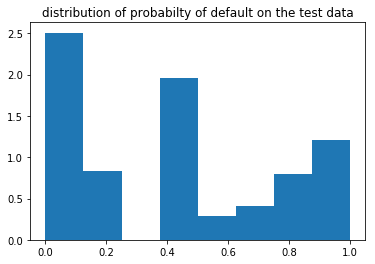

the accuracy on the test data: 0.664710485133


sampling method: random_downsampled
model: RandomForestClassifier
scaling method: None
the accuracy on the resampled training data: 0.875690607735


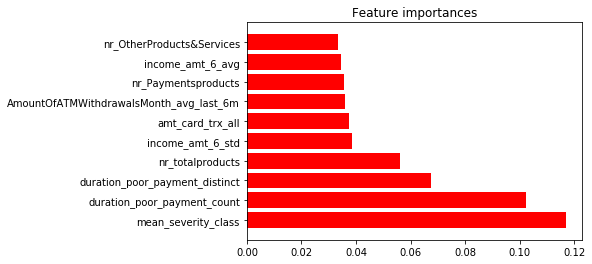

the accuracy on the training data: 0.550647381741


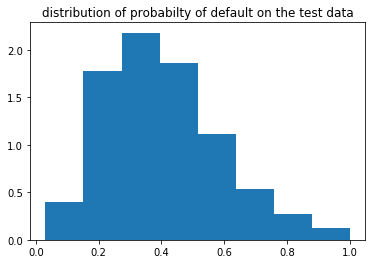

the accuracy on the test data: 0.545334507042


sampling method: random_downsampled
model: RandomForestClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 0.758747697974


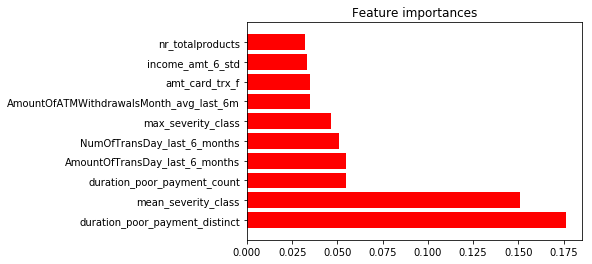

the accuracy on the training data: 0.482094606986


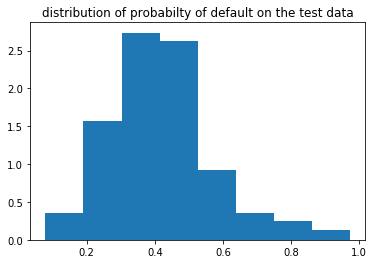

the accuracy on the test data: 0.482834507042


sampling method: random_downsampled
model: RandomForestClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 0.781767955801


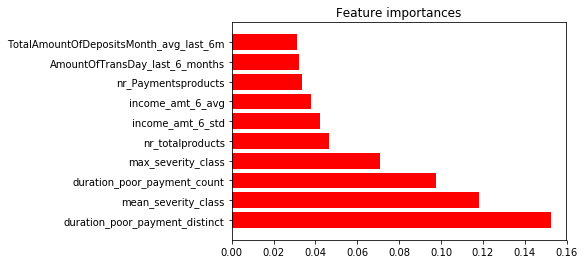

the accuracy on the training data: 0.558557787532


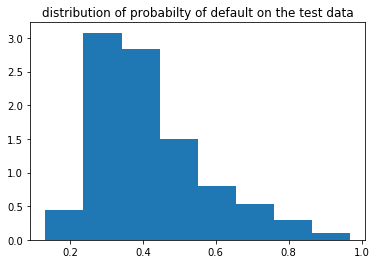

the accuracy on the test data: 0.558489827856


sampling method: random_downsampled
model: GradientBoostingClassifier
scaling method: None
the accuracy on the resampled training data: 1.0


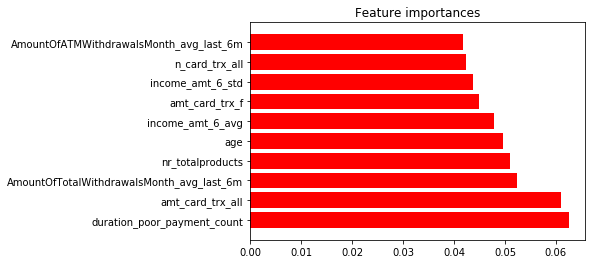

the accuracy on the training data: 0.659644704185


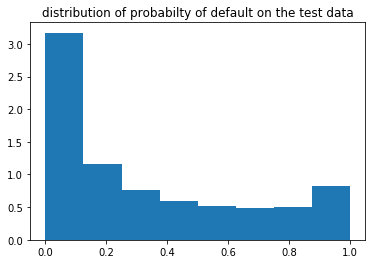

the accuracy on the test data: 0.654391627543


sampling method: random_downsampled
model: GradientBoostingClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 1.0


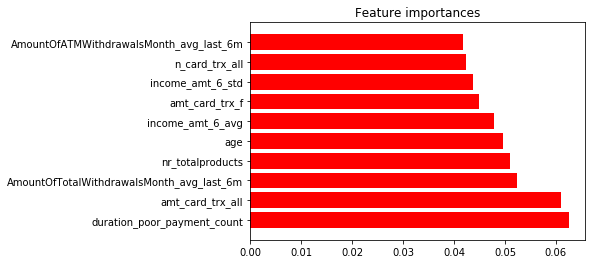

the accuracy on the training data: 0.659424631072


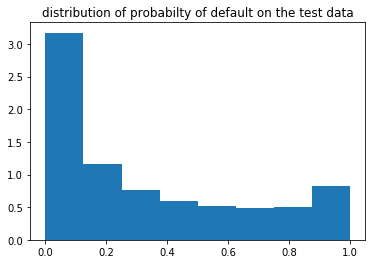

the accuracy on the test data: 0.654098200313


sampling method: random_downsampled
model: GradientBoostingClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 1.0


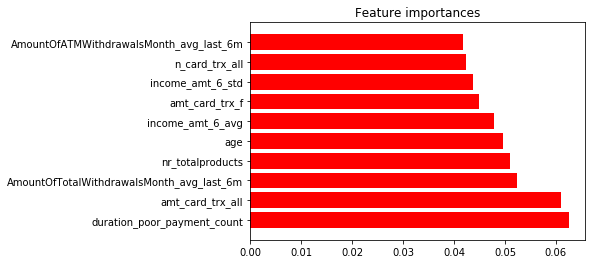

the accuracy on the training data: 0.65977919331


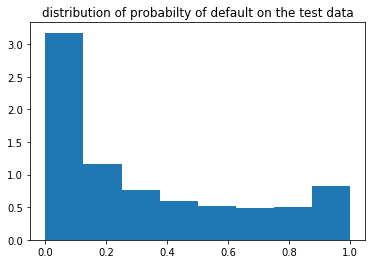

the accuracy on the test data: 0.654440532081


sampling method: SMOTE_oversampled
model: DecisionTreeClassifier
scaling method: None
the accuracy on the resampled training data: 0.975199389523


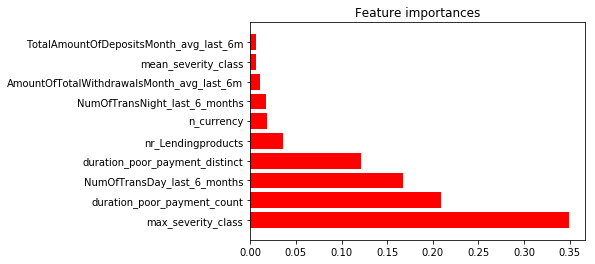

the accuracy on the training data: 0.976170972356


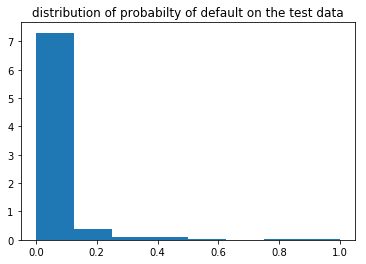

the accuracy on the test data: 0.96933685446


sampling method: SMOTE_oversampled
model: DecisionTreeClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 0.975187081528


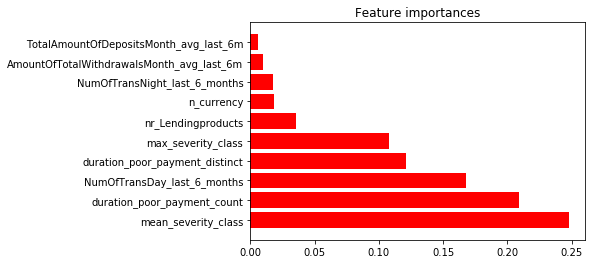

the accuracy on the training data: 0.976158746072


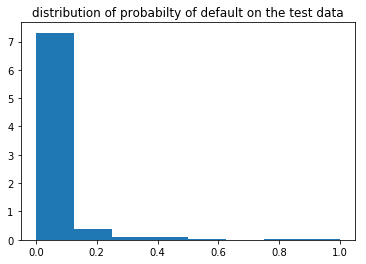

the accuracy on the test data: 0.969287949922


sampling method: SMOTE_oversampled
model: DecisionTreeClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 0.975217851516


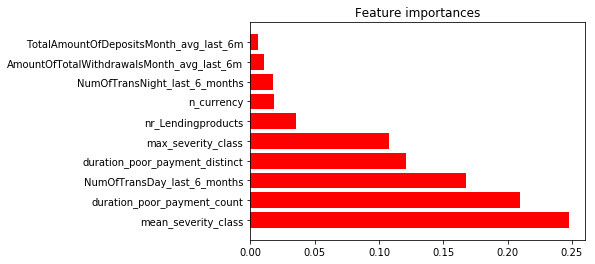

the accuracy on the training data: 0.976207651209


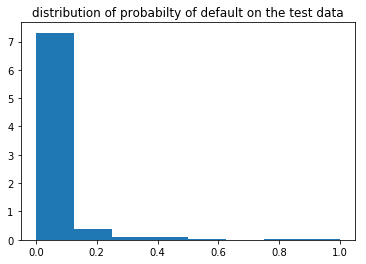

the accuracy on the test data: 0.969679186228


sampling method: SMOTE_oversampled
model: RandomForestClassifier
scaling method: None
the accuracy on the resampled training data: 0.935481488775


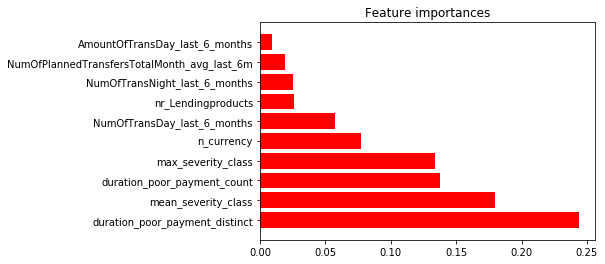

the accuracy on the training data: 0.914318201269


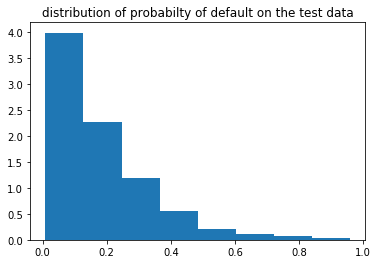

the accuracy on the test data: 0.910162363067


sampling method: SMOTE_oversampled
model: RandomForestClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 0.929893658921


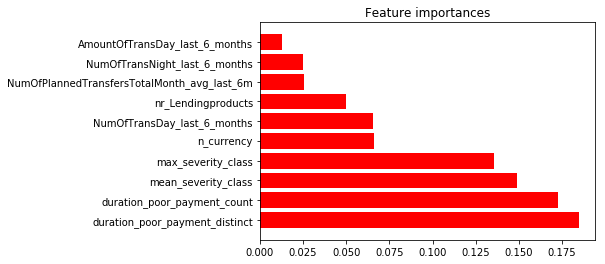

the accuracy on the training data: 0.895685344353


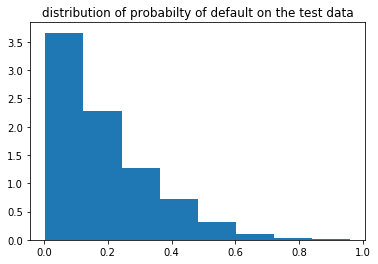

the accuracy on the test data: 0.895295383412


sampling method: SMOTE_oversampled
model: RandomForestClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 0.937653849941


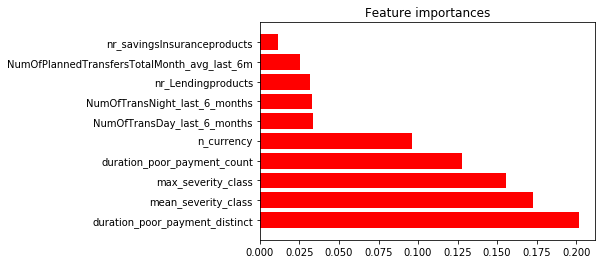

the accuracy on the training data: 0.916849042071


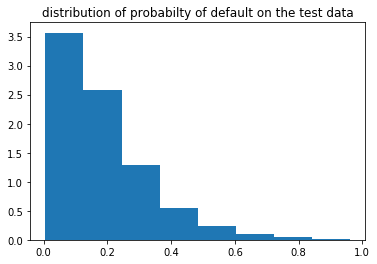

the accuracy on the test data: 0.912852112676


sampling method: SMOTE_oversampled
model: GradientBoostingClassifier
scaling method: None
the accuracy on the resampled training data: 0.998326112643


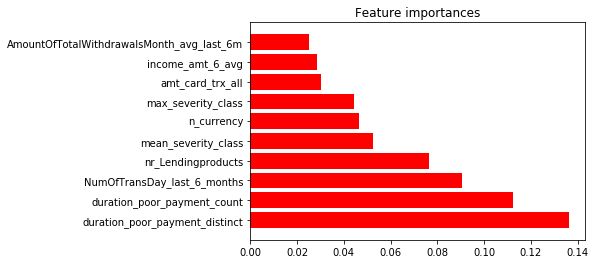

the accuracy on the training data: 0.996674450734


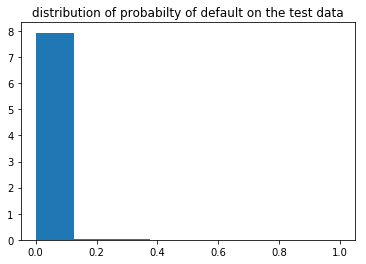

the accuracy on the test data: 0.991637323944


sampling method: SMOTE_oversampled
model: GradientBoostingClassifier
scaling method: MinMaxScaler(copy=True, feature_range=(0, 1))
the accuracy on the resampled training data: 0.998295342655


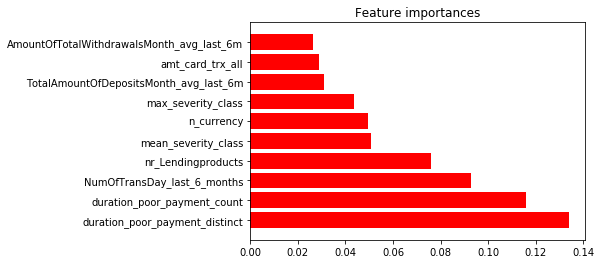

the accuracy on the training data: 0.996613319314


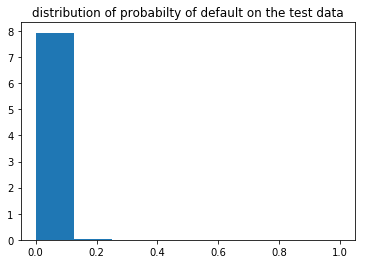

the accuracy on the test data: 0.99144170579


sampling method: SMOTE_oversampled
model: GradientBoostingClassifier
scaling method: StandardScaler(copy=True, with_mean=True, with_std=True)
the accuracy on the resampled training data: 0.99830765065


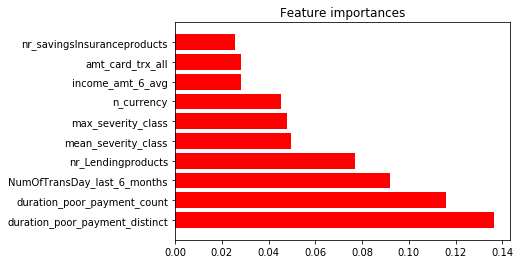

the accuracy on the training data: 0.996637771882


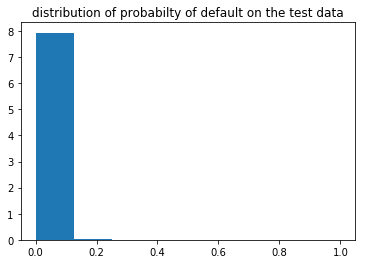

the accuracy on the test data: 0.99144170579




In [14]:
# ==============================================================
# Define metrics dataframe
# ==============================================================
metrics_df = pd.DataFrame(columns = ['model','best_parameters',
                                     'sampling_method', 'scaling_method',
                                     'recall_score_train', 'recall_score_test', 
                                     'precision_score_train', 'precision_score_test', 
                                     'accuracy_score_train', 'accuracy_score_test',
                                     'f1_score_train','f1_score_test'])

# ==============================================================
# Loop over different combinations
# ==============================================================
i = 0
# ------------------------- Sampling method --------------------
for sampling_method in sampling_methods:
    df_majority = df_train[df_train.default==0]
    df_minority = df_train[df_train.default==1]
    if sampling_method == "random_oversampled":
        X_train_res, y_train_res = ut.sample_method (method= sampling_method, 
                                                  n_ratio=1, 
                                                  sample_vector=df_minority, stay_vector=df_majority)
    else:
        X_train_res, y_train_res = ut.sample_method (method= sampling_method,
                                                  n_ratio=1
                                                  , sample_vector=df_majority, stay_vector=df_minority)
    
    # --------------------------- models ------------------------
    for model in models:
        clf_model = model
        # ------------------------- scaling method --------------------
        for scaling_method in scaling_methods:
            if scaling_method == 'None':
                pipeline = Pipeline([('clf', clf_model)])
            else:
                pipeline = Pipeline([('scl', scaling_method),
                                     ('clf', clf_model)])
            
            print(str('sampling method: ')+str(sampling_method)+str( "\n")
                 +str('model: ')+str(pipeline.named_steps.clf.estimator).split('(',1)[0] +str( "\n")
                 +str('scaling method: ')+str(scaling_method))
            
            # ---------------- fit the model to resampled data ---------------
            model = pipeline.fit(X_train_res, y_train_res)
            t = 0.4
            y_hat_train_res = model.predict_proba(X_train_res)[:,1]
            y_hat_train_res[y_hat_train_res > t] = 1
            y_hat_train_res[y_hat_train_res <= t] = 0
            print('the accuracy on the resampled training data: '+str(accuracy_score(y_train_res, y_hat_train_res)))
            ut.plot_feature_importances(model,10,df_train)
        
            # ---------------- predict probability and decide classes based on threshold ---------------
            y_hat_train_pd = model.predict_proba(X_train)[:,1]
            y_hat_train_pd[y_hat_train_pd > t] = 1
            y_hat_train_pd[y_hat_train_pd <= t] = 0
            print('the accuracy on the training data: '+str(accuracy_score(y_train, y_hat_train_pd)))
            
            y_hat_test_pd = model.predict_proba(X_test)[:,1]
            plt.hist(y_hat_test_pd, bins = 8, label = 'histogram', density = True)
            plt.title('distribution of probabilty of default on the test data')
            plt.show()
            
            y_hat_test_pd[y_hat_test_pd > t] = 1
            y_hat_test_pd[y_hat_test_pd <= t] = 0
            print('the accuracy on the test data: '+str(accuracy_score(y_test, y_hat_test_pd))+str("\n\n"))
            
            #y_hat_train = model.predict(X_train)
            #y_hat_test = model.predict(X_test)

            # -------------------------------- Save the metrics --------------------------------
            metrics_df.loc[i,'model'] = str(pipeline.named_steps.clf.estimator).split('(',1)[0]
            metrics_df.loc[i,'best_parameters'] = str(pipeline.named_steps.clf.best_params_)
            metrics_df.loc[i,'sampling_method'] = sampling_method
            metrics_df.loc[i,'scaling_method'] = scaling_method
            metrics_df.loc[i,'precision_score_train'] = average_precision_score(y_train, y_hat_train_pd)
            metrics_df.loc[i,'precision_score_test'] = average_precision_score(y_test, y_hat_test_pd)
            metrics_df.loc[i,'recall_score_train'] = recall_score(y_train, y_hat_train_pd)
            metrics_df.loc[i,'recall_score_test'] = recall_score(y_test, y_hat_test_pd)
            metrics_df.loc[i,'accuracy_score_train'] = accuracy_score(y_train, y_hat_train_pd)
            metrics_df.loc[i,'accuracy_score_test'] = accuracy_score(y_test, y_hat_test_pd)
            metrics_df.loc[i,'f1_score_train'] = f1_score(y_train, y_hat_train_pd)
            metrics_df.loc[i,'f1_score_test'] = f1_score(y_test, y_hat_test_pd)
            metrics_df.loc[i,'roc_train'] = roc_auc_score(y_train, y_hat_train_pd)
            metrics_df.loc[i,'roc_test'] = roc_auc_score(y_test, y_hat_test_pd)
            importances = model.named_steps['clf'].best_estimator_.feature_importances_
            metrics_df.loc[i,'important_features'] = str(X_train.columns[np.argsort(importances)[::-1][0:10]])

            
            i = i+1
            

In [15]:
metrics_df.head(50)

,model,best_parameters,sampling_method,scaling_method,recall_score_train,recall_score_test,precision_score_train,precision_score_test,accuracy_score_train,accuracy_score_test,f1_score_train,f1_score_test,roc_train,roc_test,important_features
0,DecisionTreeClassifier,"{'max_depth': 12, 'class_weight': 'balanced'}",random_oversampled,None,0.959484,0.458904,0.0239999,0.00960619,0.748554,0.737578,0.0482229,0.0243636,0.853314,0.599243,"Index([u'max_severity_class', u'duration_poor_..."
1,DecisionTreeClassifier,"{'max_depth': 12, 'class_weight': 'balanced'}",random_oversampled,"MinMaxScaler(copy=True, feature_range=(0, 1))",0.959484,0.465753,0.0239976,0.00972888,0.74853,0.737627,0.0482184,0.0247228,0.853302,0.602668,"Index([u'mean_severity_class', u'duration_poor..."
2,DecisionTreeClassifier,"{'max_depth': 12, 'class_weight': 'balanced'}",random_oversampled,"StandardScaler(copy=True, with_mean=True, with...",0.959484,0.465753,0.0239987,0.00973109,0.748542,0.737725,0.0482206,0.0247318,0.853308,0.602717,"Index([u'mean_severity_class', u'duration_poor..."
3,RandomForestClassifier,"{'max_depth': 8, 'class_weight': {0: 1, 1: 1}}",random_oversampled,None,0.941068,0.650685,0.0243338,0.0144994,0.760291,0.750342,0.0495443,0.0358829,0.850076,0.700872,"Index([u'mean_severity_class', u'duration_poor..."
4,RandomForestClassifier,"{'max_depth': 8, 'class_weight': {0: 1, 1: 1}}",random_oversampled,"MinMaxScaler(copy=True, feature_range=(0, 1))",0.937385,0.534247,0.0263748,0.0122106,0.781088,0.771127,0.053797,0.0322581,0.858714,0.653538,"Index([u'duration_poor_payment_count', u'mean_..."
5,RandomForestClassifier,"{'max_depth': 8, 'class_weight': {0: 1, 1: 1}}",random_oversampled,"StandardScaler(copy=True, with_mean=True, with...",0.950276,0.609589,0.0240939,0.0131176,0.753702,0.744718,0.0487321,0.0329752,0.851332,0.677640,"Index([u'duration_poor_payment_distinct', u'me..."
6,GradientBoostingClassifier,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",random_oversampled,None,1,0.205479,0.273276,0.018279,0.982345,0.97188,0.429249,0.0944882,0.991114,0.591435,"Index([u'income_amt_6_avg', u'duration_poor_pa..."
7,GradientBoostingClassifier,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",random_oversampled,"MinMaxScaler(copy=True, feature_range=(0, 1))",1,0.205479,0.286091,0.0187886,0.983433,0.972809,0.4449,0.0974026,0.991661,0.591903,"Index([u'amt_card_trx_all', u'income_amt_6_avg..."
8,GradientBoostingClassifier,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",random_oversampled,"StandardScaler(copy=True, with_mean=True, with...",1,0.205479,0.273276,0.0182533,0.982345,0.971831,0.429249,0.0943396,0.991114,0.591411,"Index([u'income_amt_6_avg', u'duration_poor_pa..."
9,DecisionTreeClassifier,"{'max_depth': 8, 'class_weight': 'balanced'}",random_downsampled,None,0.810313,0.650685,0.0144708,0.0114763,0.67417,0.665591,0.0319651,0.0270347,0.741786,0.658191,"Index([u'max_severity_class', u'duration_poor_..."


In [16]:
from subprocess import call
metrics_df_spark = spark.createDataFrame(metrics_df.astype(str))
metrics_df_spark.repartition(1).write.option("header","true").csv('metrics_df_v3_2.csv')
call(["hadoop","fs","-copyToLocal", 'metrics_df_v3_2.csv']) 

0